# notebook for computing time resolution vs Nphe of calibration pulses using real filter wheel scan data

for questions ask Julian Sitarek (jsitarek (at) uni.lodz.pl) 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from ctapipe_io_lst import LSTEventSource
from ctapipe.io import event_source
from traitlets.config.loader import Config 

from ctapipe.image.extractor import LocalPeakWindowSum

from lstchain.calib.camera.r0 import LSTR0Corrections
from lstchain.calib.camera.calibrator import LSTCameraCalibrator

from lstchain.calib.camera.time_correction_calculate import TimeCorrectionCalculate 
from lstchain.calib.camera.pulse_time_correction import PulseTimeCorrection


plt.rcParams['font.size'] = 25

/home/jsitarek/anaconda3/envs/lst-dev/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# prepare the calibration, and specify some settings and input data
charge_config = Config({
    "LocalPeakWindowSum":{
        "window_shift":4,
        "window_width":8
    }
})

calib_file = "data20201123/calibration.Run3016.0000.hdf5"
calib_time_file = "data20201123/time_calibration.Run3016.0000.hdf5"
drs4file="data20201123/drs4_pedestal.Run3015.0000.fits"
data_dir='data20201123/'


geom = CameraGeometry.from_name('LSTCam-002')

# loop over those runs
runs=[3017, 3022, 3032, 3037, 3043, 3048, 3054]
skipevents=150 # skip first events
numevents=5000 # number of events to be processed per run (not counting the skipped ones)

minnphe = 5   # time resolution curve will be computed in range minnphe - maxnphe
maxnphe = 70
mineventfit = 50 # for the fits we need at least mineventfit events per charge bin per pixel

# estimate where to look for the pulses (to lower the bias from the pedestal fluctuations)

EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7f50724cad50>
mean time in range: 13.634995971206681  to  22.239940897812463
using slices:  9  to  34


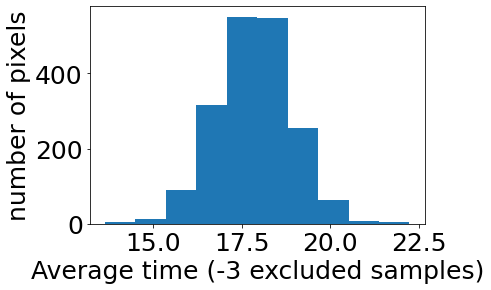

In [3]:
data_path = data_dir+f'LST-1.1.Run0{runs[0]}.0000.fits.fz'
reader = LSTEventSource(input_url=data_path,max_events=1000)

r1_dl1_calibrator_test = LSTCameraCalibrator(calibration_path=calib_file,
                                            extractor_product="LocalPeakWindowSum",
                                            time_calibration_path=calib_time_file,
                                            config=charge_config,
                                            allowed_tels=[1],
                                            subarray=reader.subarray)
minv = np.min(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)
maxv = np.max(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)
plt.hist(r1_dl1_calibrator_test.time_corrector.fan_array[0,:,0]/2)

plt.xlabel('Average time (-3 excluded samples)')
plt.ylabel('number of pixels')

margin = 4+4 # +-4 slices of integration window and +-4 slices 
offset = 3 # first 3 slices are removed
print('mean time in range:',minv,' to ', maxv)
firstslice = int(minv - margin + offset + 0.5)
lastslice = int(maxv + margin + offset+0.5)+1
firstslice = max (firstslice, 3)
lastslice = min (lastslice, 39)
print("using slices: ",firstslice, " to ", lastslice)

# fill the signal tables 
new method starts here: instead of directly computing RMS of arrival time we will make fits for each pixel and charge bin, first get all the data into an 2D array of lists

In [4]:
bins=np.arange(minnphe,maxnphe)
nbins=bins.shape[0]+1
npix=1855

allcharges = np.empty((npix,nbins), dtype=object)
alltimes = np.empty((npix,nbins), dtype=object)
for i in range(npix):
    for j in range(nbins):
        allcharges[i,j]=[]
        alltimes[i,j]=[]

for run in runs:
    print(f"processing run {run}")
    data_path = data_dir+f'LST-1.1.Run0{run}.0000.fits.fz'
    reader = LSTEventSource(input_url=data_path,
                            max_events=skipevents+numevents)

    r0_r1_calibrator = LSTR0Corrections(pedestal_path=drs4file,
                                    r1_sample_start=firstslice,
                                    r1_sample_end=lastslice)
    
    r1_dl1_calibrator = LSTCameraCalibrator(calibration_path=calib_file,
                                        extractor_product="LocalPeakWindowSum",
                                        time_calibration_path=calib_time_file,
                                        config=charge_config,
                                        allowed_tels=[1],
                                        subarray=reader.subarray)
    
    # this switches off the DRS4 time calibration (for tests)
    #r1_dl1_calibrator.time_corrector=None
    
    # FIXME: we should exclude those, if there are some bad pixels
    bad_pix = np.where(r1_dl1_calibrator.mon_data.tel[1].calibration.dc_to_pe[0]<0)[0]
    print("bad pixels: ", bad_pix)

    meanchs = []
    for i, ev in enumerate(reader):
        r0_r1_calibrator.calibrate(ev)
        
        if i%100 == 1:
            print(f"event {i}")
        #print(ev.lst.tel[1].evt.tib_masked_trigger)
        if i<skipevents:
            continue
        
        r1_dl1_calibrator(ev)
        
        charges=ev.dl1.tel[1].image
        times=ev.dl1.tel[1].peak_time
        evtmean=np.mean(charges)
        evtstd=np.std(charges)
        
        avrtime = np.mean(times[charges>5])
        times-=avrtime
        
        # a few hardcoded cuts to deal with the lack of proper trigger tags
        if evtmean<4:  # exclude pedestal events and small showers
            continue
        if evtstd>evtmean:  # exclude (big) showers
            continue
        if np.sum(charges>5)<300:
            continue  # not enought events to get average event time
            
        meanchs.append(evtmean)
        ibins=np.digitize(charges, bins)                    
        for ipix in range(npix):
            ibin=ibins[ipix]
            allcharges[ipix,ibin].append(charges[ipix])
            alltimes[ipix,ibin].append(times[ipix])
             
        #print(np.std(times), evtmean,evtstd, charges[0:10])
    print("<Nphe>=",np.mean(meanchs), " from ",len(meanchs), " events")                                 

processing run 3017
EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7f507197ad50>
bad pixels:  []


/home/jsitarek/anaconda3/envs/lst-dev/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
event 2701
event 2801
event 2901
event 3001
event 3101
event 3201
event 3301
event 3401
event 3501
event 3601
event 3701
event 3801
event 3901
event 4001
event 4101
event 4201
event 4301
event 4401
event 4501
event 4601
event 4701
event 4801
event 4901
event 5001
event 5101
<Nphe>= 22.871214  from  1912  events
processing run 3022
EXTRACTOR <ctapipe.image.extractor.LocalPeakWindowSum object at 0x7f50637f4a10>
bad pixels:  []
event 1
event 101
event 201
event 301
event 401
event 501
event 601
event 701
event 801
event 901
event 1001
event 1101
event 1201
event 1301
event 1401
event 1501
event 1601
event 1701
event 1801
event 1901
event 2001
event 2101
event 2201
event 2301
event 2401
event 2501
event 2601
e

# example of fits for a single pixel

mean Nphe =  5.520612 , num entries =  116
[ 0.1271181  -0.1820645   0.70644703 20.55313073]


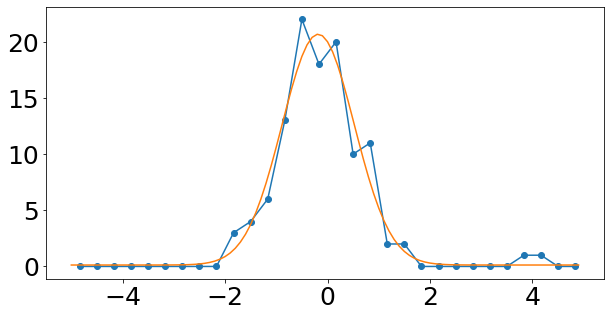

mean Nphe =  6.542788 , num entries =  170
[ 0.59867685 -0.21481945  0.57995691 34.40323322]


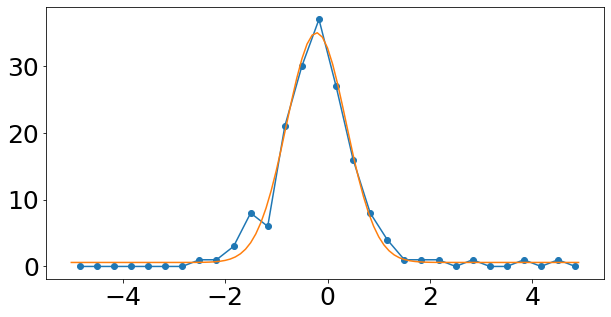

mean Nphe =  7.558959 , num entries =  216
[ 0.44811758 -0.24895756  0.60962028 43.96693198]


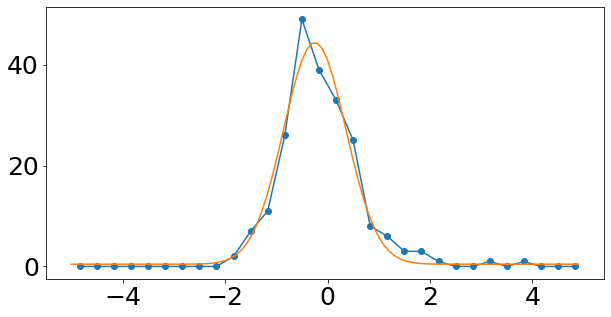

mean Nphe =  8.508579 , num entries =  259
[ 0.36006002 -0.25644229  0.64722982 50.99515712]


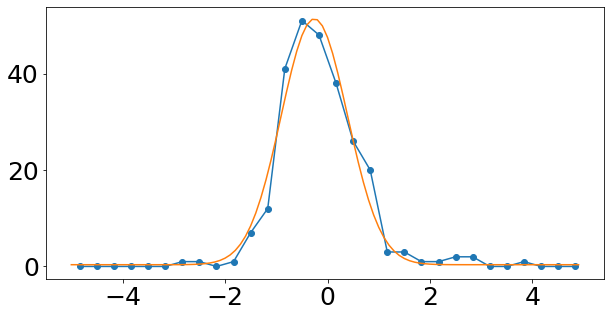

mean Nphe =  9.477932 , num entries =  288
[ 0.47883017 -0.20883693  0.60844012 59.8057268 ]


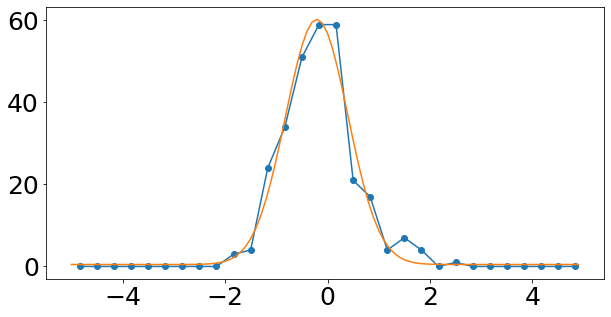

mean Nphe =  10.504115 , num entries =  322
[ 0.53809304 -0.14414004  0.52850287 76.9591371 ]


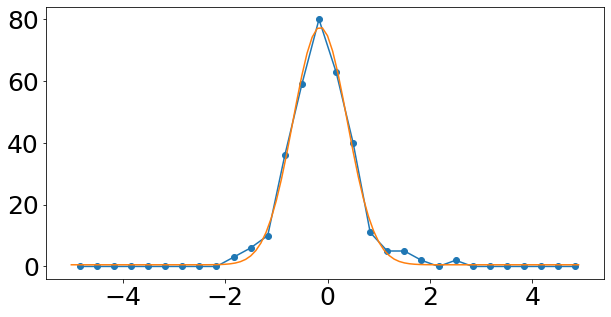

mean Nphe =  11.514699 , num entries =  312
[ 0.24927259 -0.17914278  0.57830518 70.02451992]


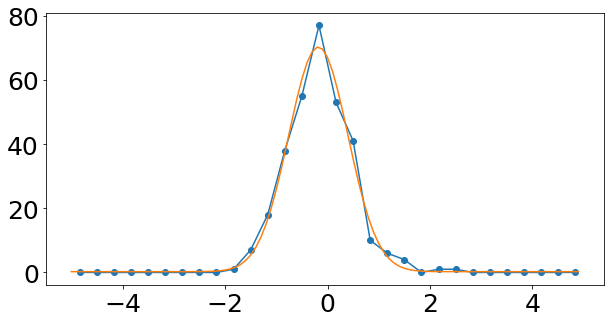

mean Nphe =  12.497185 , num entries =  332
[ 0.44926939 -0.18798035  0.5223174  81.09491989]


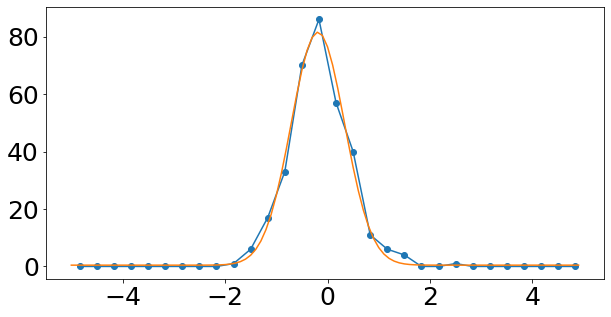

mean Nphe =  13.480983 , num entries =  365
[ 0.51703406 -0.21215861  0.51490151 90.26058446]


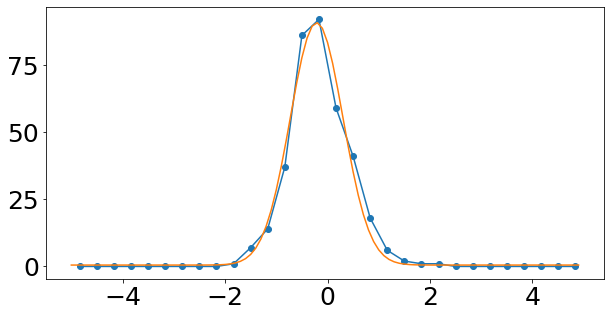

mean Nphe =  14.497594 , num entries =  306
[ 0.42552226 -0.15634848  0.54703505 71.28341455]


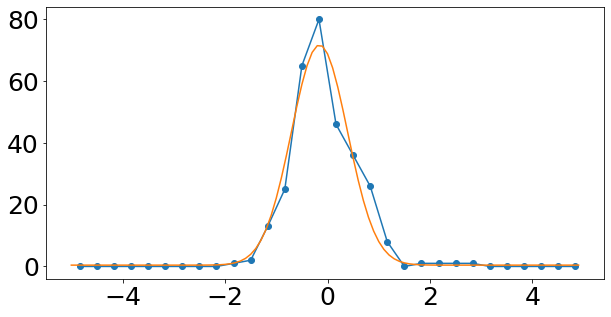

mean Nphe =  15.509711 , num entries =  295
[ 0.30167142 -0.15098826  0.54974491 69.1699571 ]


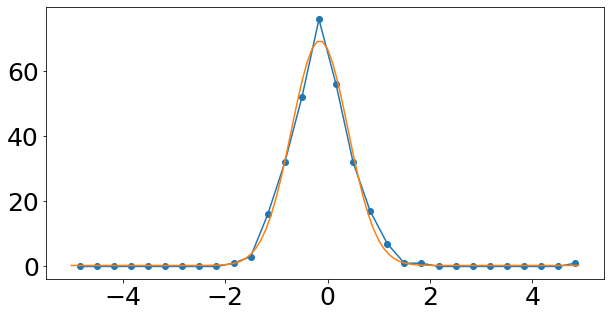

mean Nphe =  16.494991 , num entries =  304
[-0.10106685 -0.09586422  0.57825331 70.60807302]


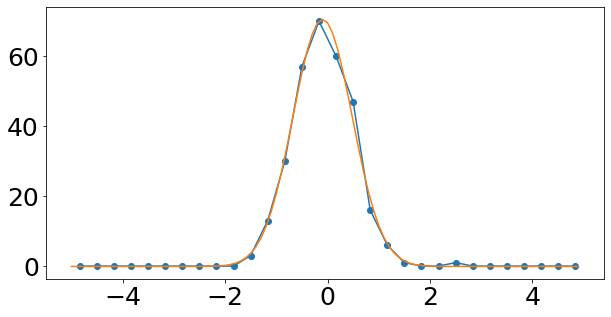

mean Nphe =  17.513763 , num entries =  308
[ 3.80795524e-02 -1.00436152e-01  5.04828349e-01  8.08317518e+01]


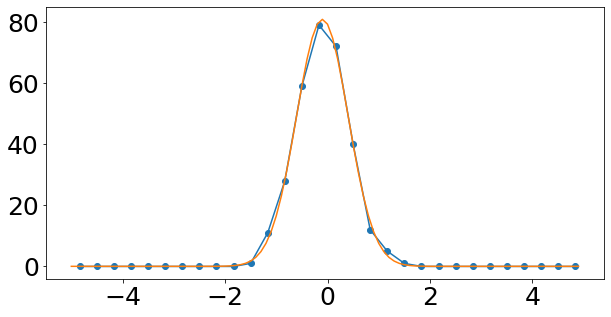

mean Nphe =  18.505497 , num entries =  289
[ 0.28785574 -0.15225681  0.49377628 75.50597684]


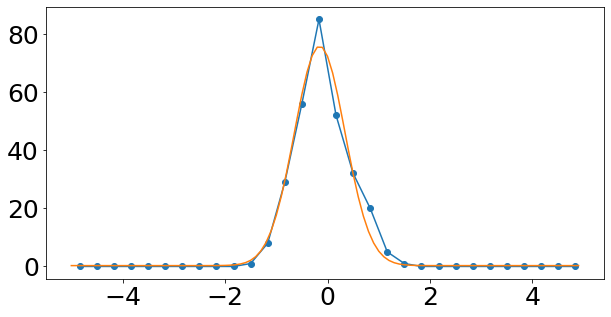

mean Nphe =  19.502392 , num entries =  295
[-4.87032623e-02 -1.69814438e-01  5.28121634e-01  7.46487714e+01]


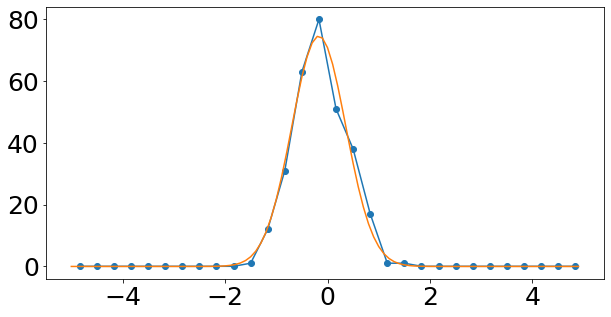

mean Nphe =  20.507677 , num entries =  275
[-0.15556875 -0.11105382  0.52666537 70.61474131]


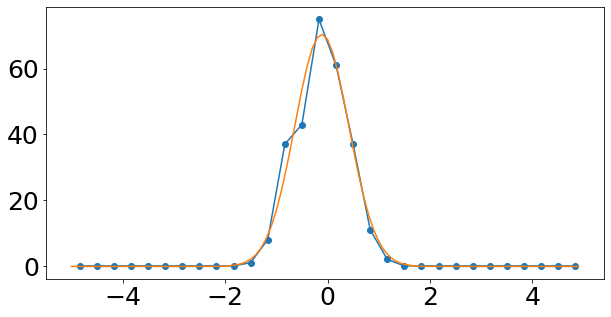

mean Nphe =  21.507393 , num entries =  275
[-0.11036779 -0.08440173  0.48311457 76.60711814]


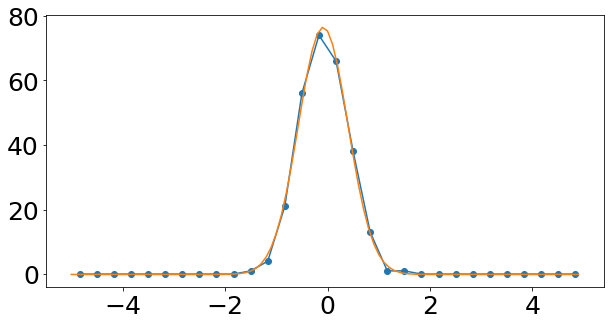

mean Nphe =  22.512695 , num entries =  303
[ 0.3297837  -0.16858359  0.46468144 83.88009798]


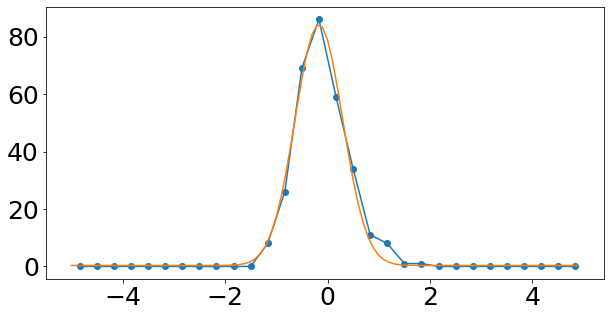

mean Nphe =  23.512249 , num entries =  305
[-9.07270514e-03 -1.02302084e-01  4.94888509e-01  8.20293213e+01]


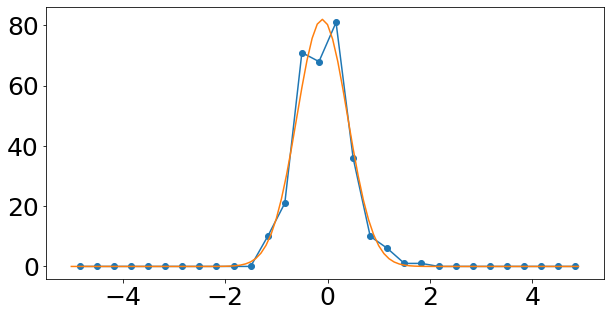

mean Nphe =  24.496944 , num entries =  323
[ 0.27453434 -0.1526834   0.42360555 98.81256938]


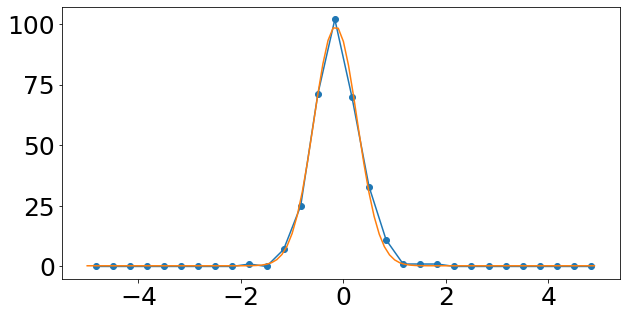

mean Nphe =  25.515562 , num entries =  308
[-3.03741941e-02 -1.47195910e-01  4.64902640e-01  8.83609808e+01]


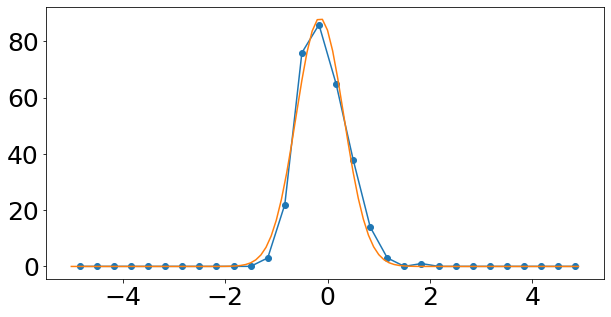

mean Nphe =  26.491938 , num entries =  351
[ 2.78217957e-01 -7.51421523e-02  4.35403095e-01  1.04653181e+02]


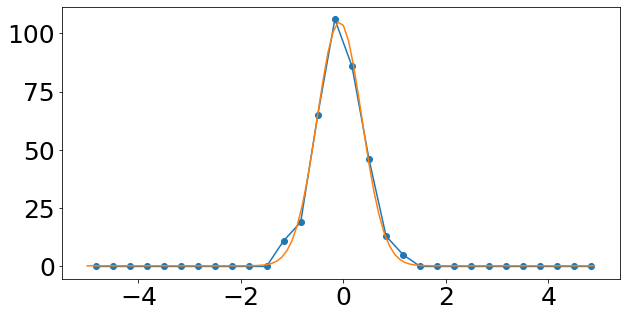

mean Nphe =  27.532084 , num entries =  377
[-2.75872530e-02 -1.45633077e-01  4.53868734e-01  1.10701176e+02]


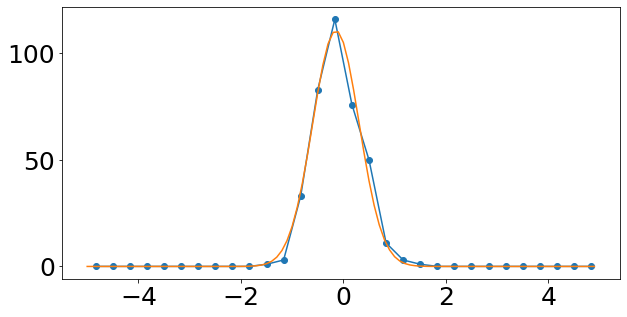

mean Nphe =  28.513165 , num entries =  376
[-1.61816892e-01 -8.38316539e-02  4.66719992e-01  1.08515433e+02]


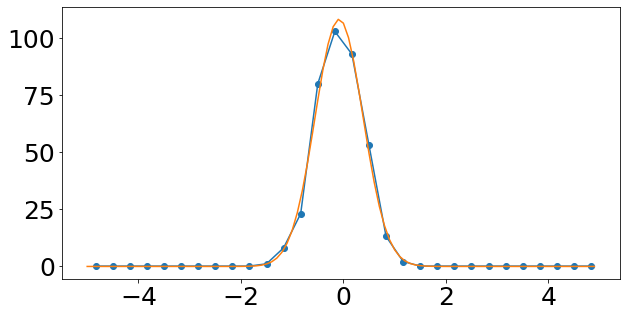

mean Nphe =  29.49933 , num entries =  405
[ 4.10715350e-01 -7.93502814e-02  4.21974726e-01  1.23748389e+02]


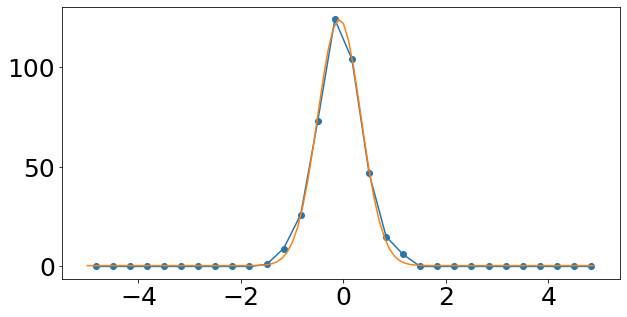

mean Nphe =  30.512684 , num entries =  371
[ -0.24696665  -0.14559201   0.47411226 106.13755645]


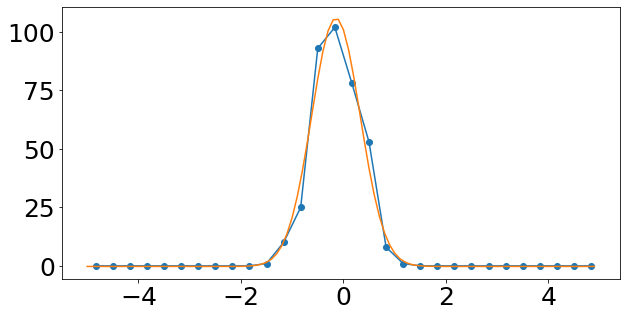

mean Nphe =  31.49136 , num entries =  394
[-2.80595083e-01 -1.11241078e-01  4.39370284e-01  1.21796660e+02]


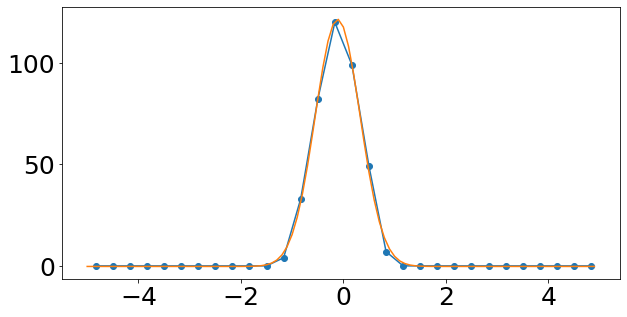

mean Nphe =  32.4978 , num entries =  426
[-1.01538175e-01 -4.41773057e-02  4.59495934e-01  1.24168420e+02]


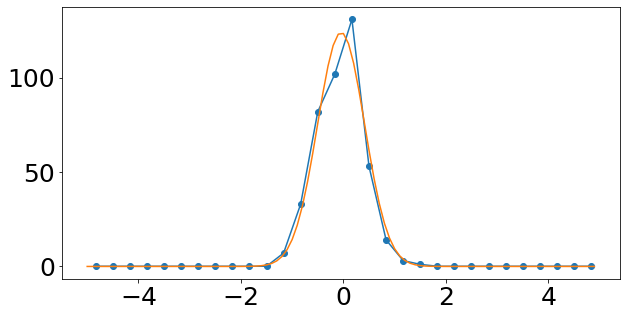

mean Nphe =  33.494183 , num entries =  379
[-2.51683142e-01 -8.52409442e-02  4.72340536e-01  1.08827799e+02]


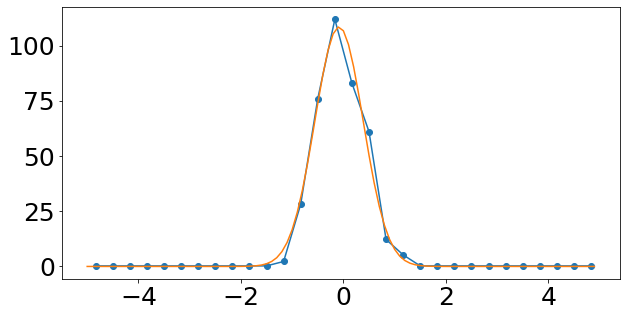

mean Nphe =  34.49216 , num entries =  348
[ -0.30501332  -0.12828857   0.45830237 103.63056513]


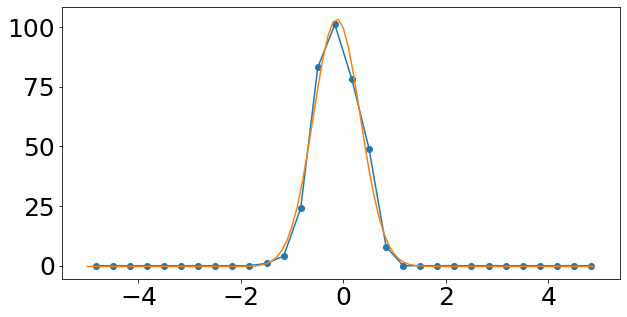

mean Nphe =  35.48414 , num entries =  323
[-1.95191080e-01 -3.97821289e-02  4.64734733e-01  9.40998878e+01]


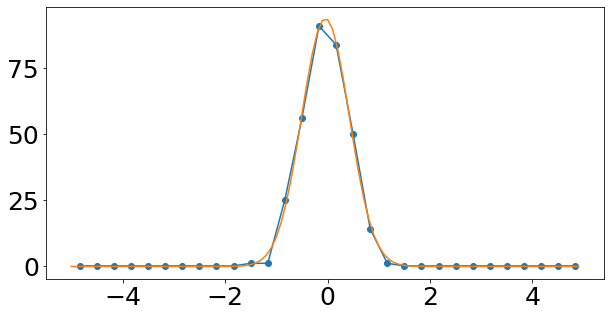

mean Nphe =  36.49407 , num entries =  276
[ 2.08603396e-01 -6.95198601e-02  3.98683878e-01  8.99722464e+01]


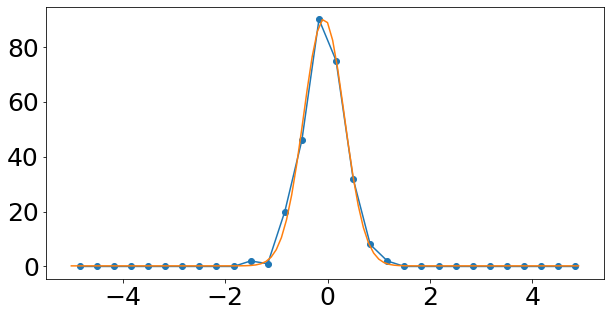

mean Nphe =  37.499264 , num entries =  269
[-0.12599399 -0.10658222  0.42319212 85.7163121 ]


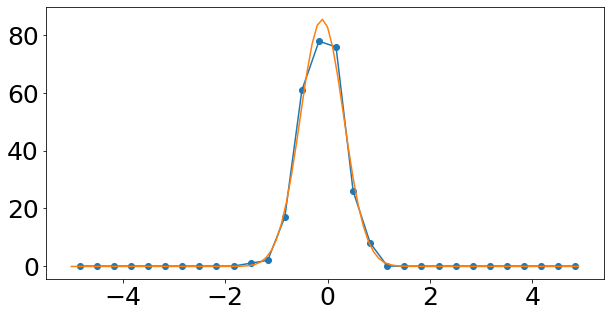

mean Nphe =  38.48408 , num entries =  238
[ 1.76829339e-01 -2.91741560e-02  4.05852408e-01  7.62444020e+01]


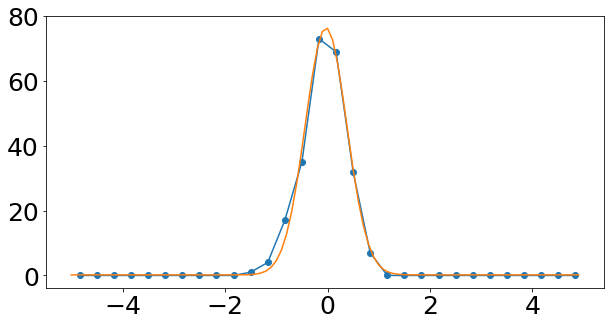

mean Nphe =  39.49553 , num entries =  197
[-0.15407179 -0.07933841  0.46048989 58.22466145]


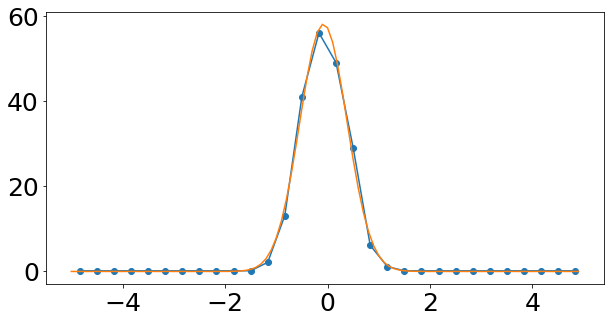

mean Nphe =  40.505974 , num entries =  168
[-0.10429476 -0.11113589  0.47588776 47.81977498]


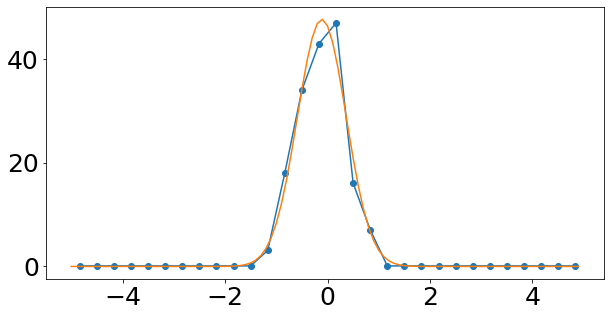

mean Nphe =  41.490475 , num entries =  146
[-0.17240991 -0.10237605  0.49005313 41.02209807]


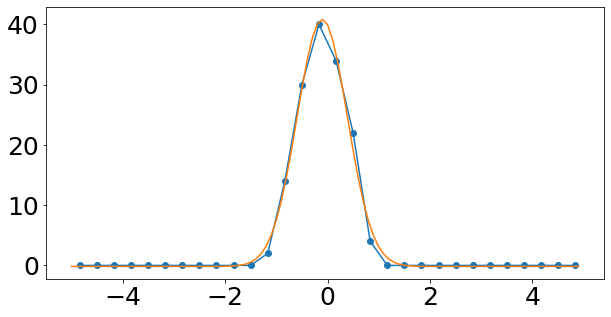

mean Nphe =  42.476475 , num entries =  113
[ 0.19516669 -0.11337008  0.36421358 39.12052019]


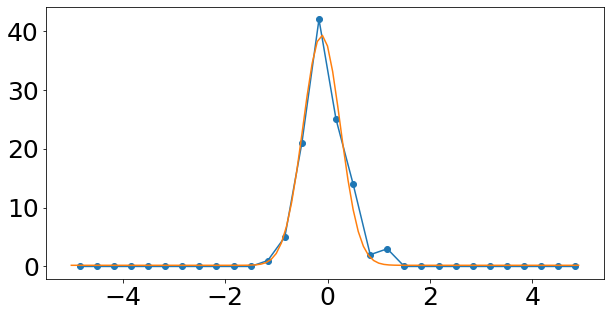

mean Nphe =  43.461613 , num entries =  88
[-0.14692957 -0.11296917  0.51546995 23.83935588]


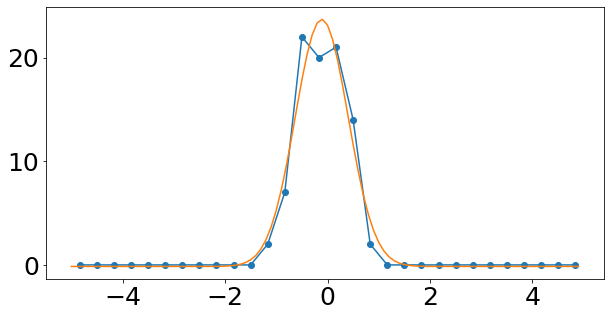

mean Nphe =  44.514763 , num entries =  72
[ 0.09668008 -0.10336504  0.3512781  26.15852577]


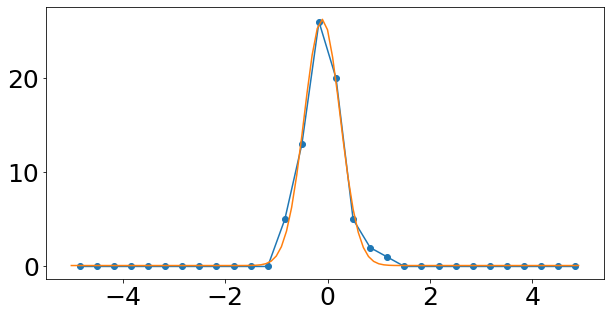

mean Nphe =  45.48721 , num entries =  73
[-1.04688091e-02 -9.04556224e-02  4.29285102e-01  2.27106898e+01]


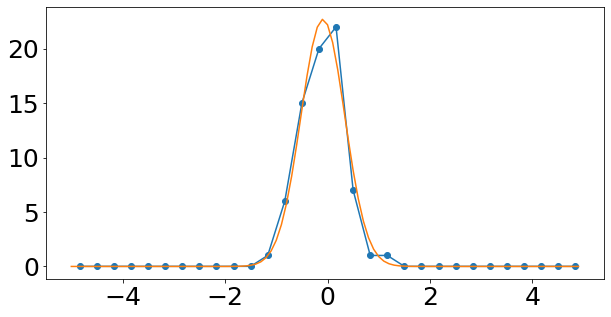

mean Nphe =  46.352776 , num entries =  55
[-0.0907494  -0.07520786  0.46255667 16.59468206]


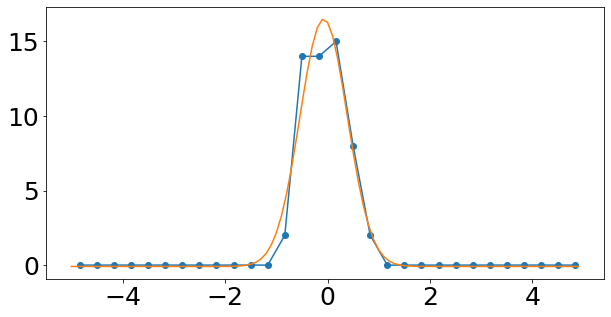

mean Nphe =  53.53534 , num entries =  52
[-0.0802198   0.01625986  0.46255937 15.64130094]


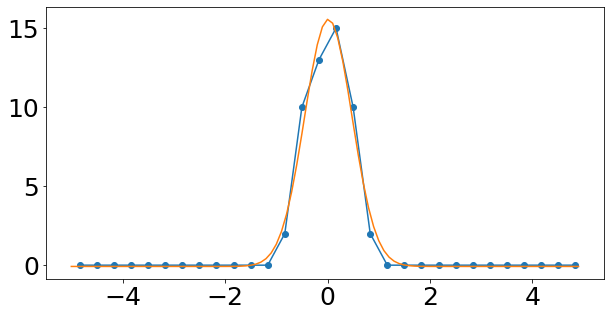

mean Nphe =  54.537334 , num entries =  67
[-1.34000306e-02 -3.77757397e-02  3.74760553e-01  2.39170578e+01]


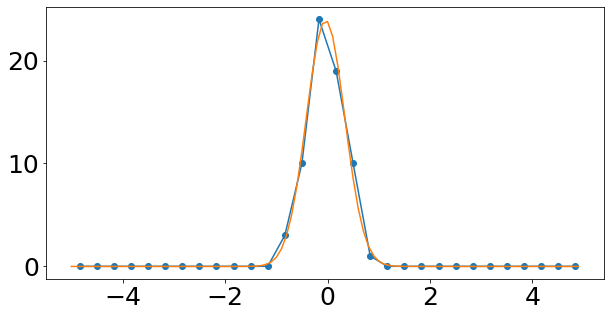

mean Nphe =  55.508102 , num entries =  60
[ 1.74572552e-02 -2.56165349e-01  4.29377938e-01  1.84201388e+01]


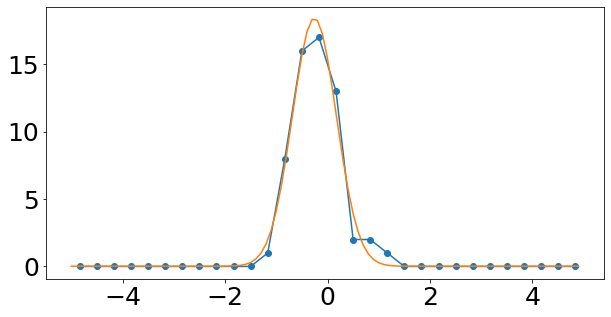

mean Nphe =  56.53328 , num entries =  77
[ 0.13190352 -0.08278027  0.31508363 30.827688  ]


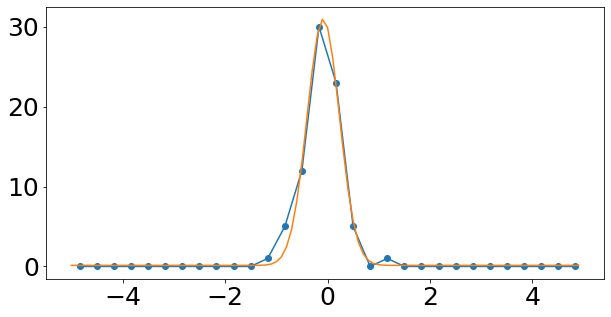

mean Nphe =  57.505684 , num entries =  78
[-7.97311473e-02 -1.30392084e-02  4.32177507e-01  2.47365515e+01]


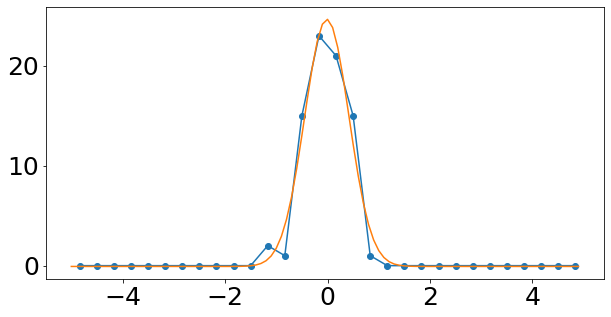

mean Nphe =  58.53884 , num entries =  79
[ 2.56125828e-02 -1.18279860e-01  3.75843725e-01  2.76798575e+01]


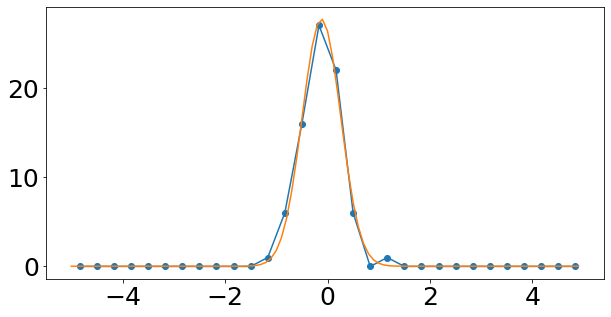

mean Nphe =  59.50662 , num entries =  92
[-0.0888429  -0.14455385  0.42821145 29.39823882]


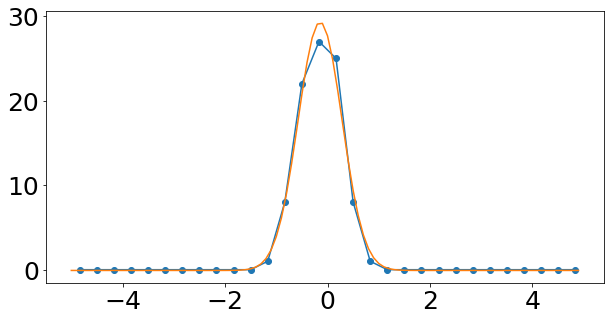

mean Nphe =  60.45329 , num entries =  83
[ 0.1460913  -0.13859424  0.33615685 31.10031297]


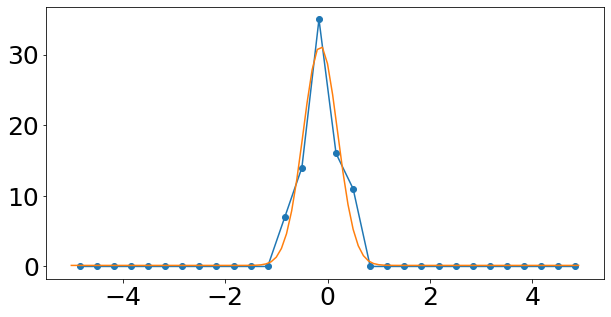

mean Nphe =  61.507477 , num entries =  66
[-1.50635448e-02 -1.15643112e-01  4.31306484e-01  2.04885036e+01]


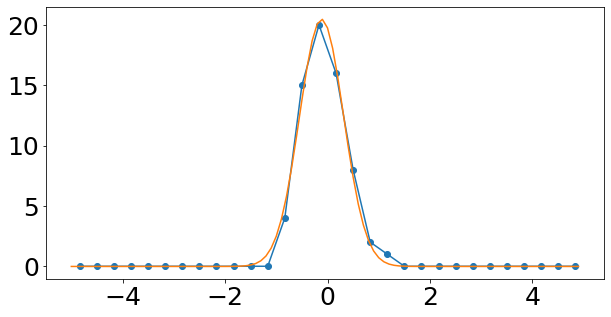

mean Nphe =  62.493572 , num entries =  92
[-0.07282701 -0.07521982  0.41743433 30.00416434]


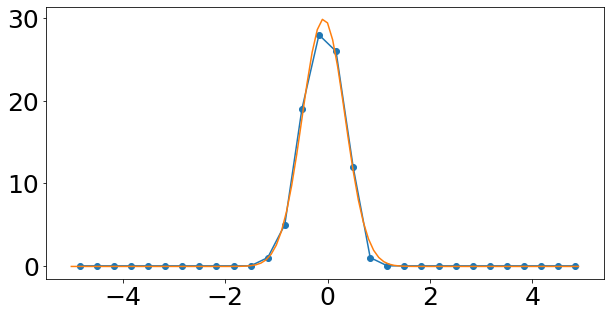

mean Nphe =  63.51842 , num entries =  91
[-0.10330291 -0.1013508   0.40406421 30.96876256]


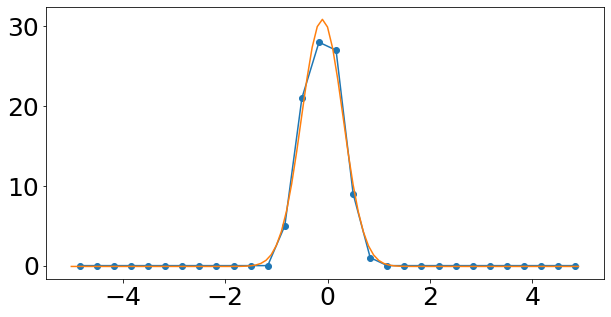

mean Nphe =  64.49754 , num entries =  85
[ 0.03163093 -0.10976164  0.39622884 28.20888618]


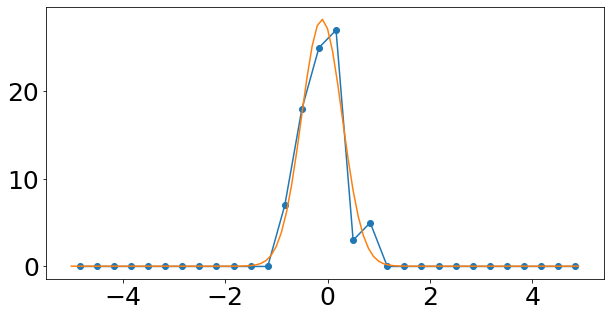

mean Nphe =  65.54101 , num entries =  78
[-0.17911692 -0.06050937  0.47600482 23.29193369]


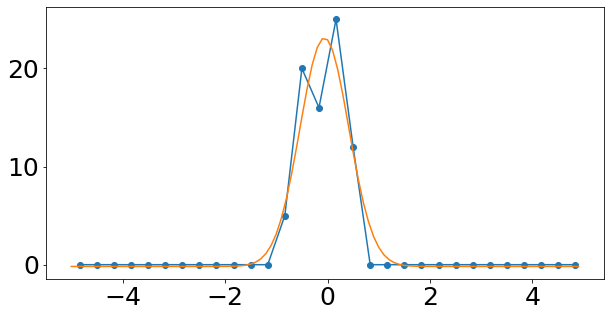

mean Nphe =  66.444336 , num entries =  86
[-0.05028209 -0.13231561  0.46656018 24.94199618]


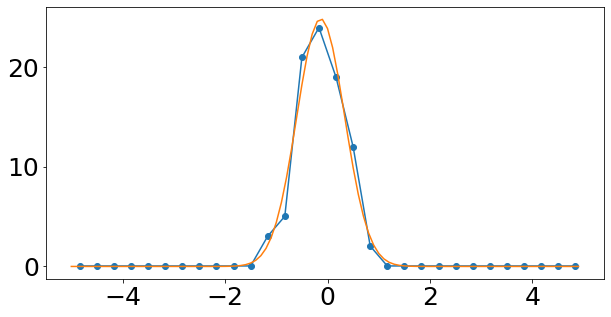

mean Nphe =  67.450294 , num entries =  68
[-0.0988961  -0.05615225  0.44531639 21.19219182]


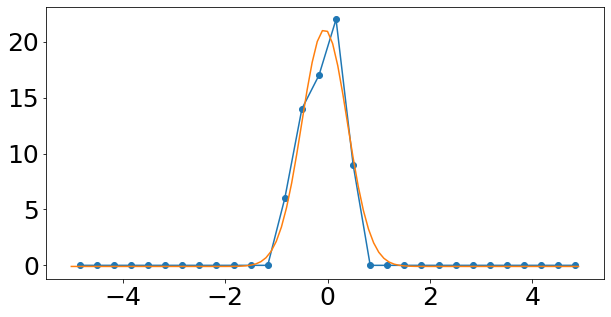

mean Nphe =  68.491295 , num entries =  93
[-0.04102344 -0.0957903   0.42920334 29.19565229]


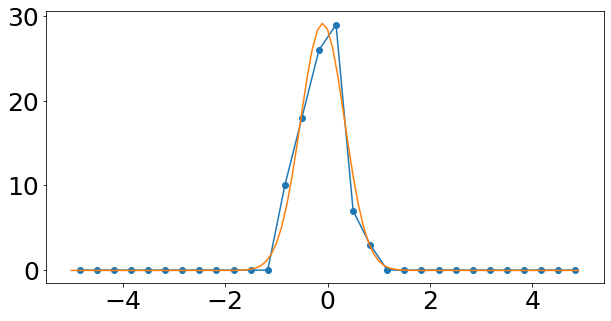

mean Nphe =  74.62077 , num entries =  542
[ 1.64398004e-01 -9.79926341e-02  3.95499462e-01  1.80581084e+02]


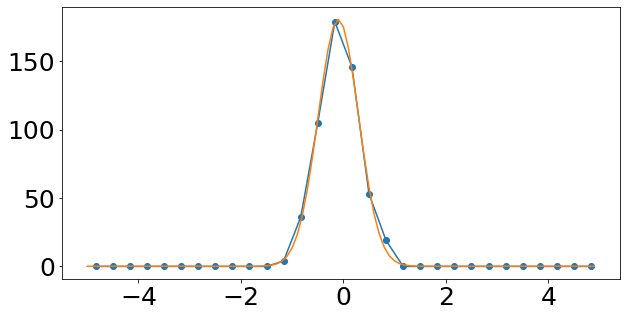

[3.79502982e-01 1.37324246e+00 5.66714824e-09]


Text(0, 0.5, 'Time resolution [ns]')

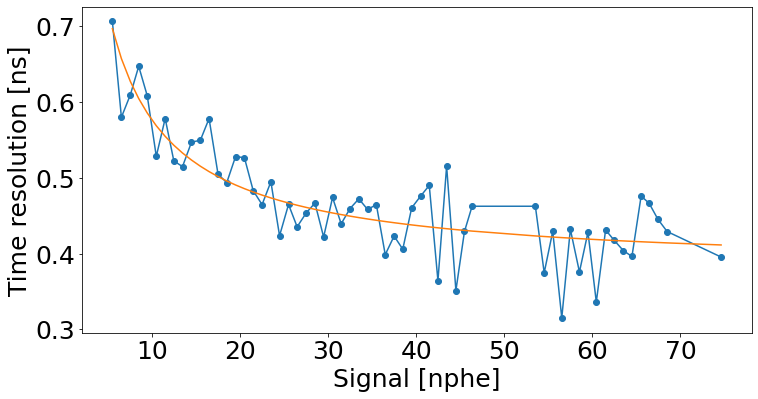

In [5]:
def fgauss (x, bgd, mean, sigma, norm):
    return bgd+ norm*np.exp(-(x-mean)**2/(2*sigma**2))


pixid=55

timeresy=[]
timeresx=[]
for binnr in range (1, nbins):
    numentries=len(alltimes[pixid,binnr])
    if numentries<mineventfit:
        continue
    meancharge=np.mean(allcharges[pixid,binnr])
    hist = np.histogram(alltimes[pixid,binnr], bins=30, range=(-5, 5))
    xs=hist[1][:-1]+0.5*(hist[1][1]-hist[1][0])
    ys=hist[0]
    print ("mean Nphe = ",meancharge, ", num entries = ", numentries)


    meanp=np.mean(alltimes[pixid,binnr])
    sigmap=np.std(alltimes[pixid,binnr])
    norm0=max(ys)
    p0 = [0.1, meanp, sigmap, norm0]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, ys, marker='o')

    pars, cov = curve_fit(f=fgauss, xdata=xs, ydata=ys, p0=p0)
    print(pars)
    xs2=np.arange(-5, 5, 0.1)
    yfit = fgauss(xs2, *pars)
    plt.plot(xs2, yfit)
    plt.show()
    
    timeresx.append(meancharge)
    timeresy.append(np.abs(pars[2]))

plt.figure(figsize=(12, 6))
plt.plot(timeresx, timeresy, marker='o')

def func (x, t0, t1, t2):
    return np.sqrt(t0**2 + t1**2/x + (t2/x)**2)

p0=[1,1,1]
pars, cov = curve_fit(f=func, xdata=timeresx, ydata=timeresy, p0=p0, bounds=(0, 20))
print(pars)
yfit = func(timeresx, *pars)

plt.plot(timeresx, yfit)
plt.xlabel("Signal [nphe]")
plt.ylabel("Time resolution [ns]")

# now fits for all the pixels, first we fit for each pixel each charge bin separately, from those results of the fit we construct the arrival time resolution vs Nphe for each pixel, and those curves we fit with a model curve to estimate the value at 5 phe

0 [0.38003338 1.31643219 1.75571773] 0.783789452154294
1 [3.66468487e-01 1.45549564e+00 1.48474720e-05] 0.7469890665153375
2 [3.73043273e-01 1.40916311e+00 8.03561775e-07] 0.7323314930928131
3 [4.18774689e-01 1.18366137e+00 9.50492269e-05] 0.6749689549285313
4 [3.96864530e-01 1.13358519e+00 9.81931519e-08] 0.6438202646343865
5 [0.36185876 1.41261639 1.56673458] 0.7926065034385517
6 [3.95491724e-01 1.31153013e+00 3.47701965e-07] 0.7074149831434376
7 [3.69412002e-01 1.38101738e+00 2.43758994e-08] 0.71965757537872
8 [3.79016599e-01 1.39890546e+00 4.91582859e-07] 0.7314648867131138
9 [3.91146870e-01 1.37828037e+00 3.34920805e-08] 0.7300186485978449
10 [3.67236878e-01 1.55103488e+00 4.55681631e-07] 0.784859708692653
11 [3.85051647e-01 1.45689479e+00 4.84876406e-07] 0.7568178474435026
12 [3.73938485e-01 1.43089879e+00 2.38895878e-11] 0.7411641259360945
13 [3.78635886e-01 1.41201293e+00 5.69993184e-08] 0.7362888291800891
14 [0.3878669  1.09355059 3.12641728] 0.8835104490104267
15 [4.02624674e

125 [3.90431942e-01 1.27670287e+00 2.63595903e-08] 0.6916871721023246
126 [3.78446549e-01 1.35535085e+00 1.10653718e-10] 0.7145746832097439
127 [3.87133552e-01 1.46029474e+00 1.27231330e-07] 0.7591867577478415
128 [3.90706930e-01 1.18019160e+00 2.38385036e-08] 0.6566752219494711
129 [3.73072582e-01 1.44559054e+00 4.63132091e-10] 0.7464111157858159
130 [3.70053240e-01 1.49659276e+00 5.43357001e-10] 0.7647858387470725
131 [3.69808935e-01 1.46767778e+00 2.02996712e-08] 0.7533752468185732
132 [0.39442357 1.31187533 1.02121312] 0.7358589379589251
133 [4.25367756e-01 4.91977731e-12 5.13079933e+00] 1.1108293294091802
134 [3.99868271e-01 1.25689147e+00 4.98139812e-11] 0.6898187202892264
135 [3.95607303e-01 1.16964515e+00 3.57540280e-09] 0.6558346557343206
136 [3.76909326e-01 1.36387505e+00 4.21891401e-09] 0.7170018613158887
137 [3.90762479e-01 1.30122394e+00 1.36531399e-09] 0.7009508276161351
138 [3.77517328e-01 1.35924829e+00 3.54507738e-11] 0.715563077215569
139 [3.76207656e-01 1.35776763e+0

249 [4.03353842e-01 1.20089570e+00 1.89174153e-11] 0.6716579635438413
250 [3.92956240e-01 1.24700410e+00 1.17218243e-09] 0.6822158411357122
251 [3.72141810e-01 1.52496701e+00 1.52900628e-10] 0.7769133813283969
252 [0.40649122 1.11398371 2.72598859] 0.8430110376034158
253 [0.37485469 1.34467251 1.39268429] 0.7613984842083054
254 [4.01728392e-01 1.28269028e+00 2.42631380e-07] 0.7003174800393315
255 [4.07424527e-01 1.30484112e+00 4.43871541e-10] 0.7116999477573808
256 [3.78165199e-01 1.42195733e+00 3.23696389e-07] 0.7398658289997968
257 [3.67816070e-01 1.48621603e+00 9.34943264e-12] 0.7596422035440856
258 [3.98590844e-01 1.34872742e+00 1.46230827e-09] 0.7229715018636007
259 [3.80078625e-01 1.42933550e+00 7.53250529e-09] 0.7436798752009401
260 [3.71474135e-01 1.34994455e+00 6.16052880e-08] 0.7088463077324625
261 [3.75412844e-01 1.34443514e+00 3.38873498e-10] 0.7088271795204425
262 [3.81756547e-01 1.39789740e+00 1.92349264e-09] 0.7325035760434367
263 [4.18469490e-01 1.23708563e+00 8.2854622

376 [3.63506478e-01 1.44523359e+00 4.54223809e-11] 0.7415369074140687
377 [0.35761001 1.55716601 1.25641314] 0.8221806792254737
378 [0.39619922 1.27472835 2.84205961] 0.8972471246345246
379 [3.82185530e-01 1.31164893e+00 1.07832643e-08] 0.7001073944912062
380 [3.65781543e-01 1.52343082e+00 3.03423870e-07] 0.7732815979343933
381 [3.87233549e-01 1.43619079e+00 1.26952727e-07] 0.74998574561228
382 [3.78353277e-01 1.33216905e+00 1.37286086e-09] 0.7057521376783276
383 [3.61858916e-01 1.43807524e+00 7.02754078e-12] 0.7379389921338115
384 [0.38715618 1.33820453 1.98415514] 0.8157959563998759
385 [3.70101670e-01 1.46473564e+00 5.53223473e-07] 0.7523731440904305
386 [4.00655989e-01 1.35909603e+00 1.52324532e-09] 0.7279791364849145
387 [3.86840556e-01 1.35504743e+00 2.17988466e-07] 0.7189411144780027
388 [3.98313873e-01 1.26193750e+00 1.09978928e-07] 0.6907613119049468
389 [0.41644092 0.90515333 2.74328537] 0.7989418865105562
390 [3.76424451e-01 1.38822767e+00 3.70379082e-08] 0.726037589438468
3

500 [3.76446216e-01 1.39860099e+00 6.59006373e-07] 0.7300196550578528
501 [3.69669380e-01 1.34728151e+00 2.28262262e-09] 0.7068867955903727
502 [0.41052942 1.00788113 2.29423825] 0.7630468165276719
503 [3.72808718e-01 1.42287415e+00 2.31764888e-07] 0.7374961098008478
504 [3.70023451e-01 1.52921302e+00 4.54925002e-11] 0.7775704766341258
505 [3.67752698e-01 1.31449688e+00 1.28333532e-10] 0.6934136251386704
506 [0.35803395 1.58615819 1.37046477] 0.8405324603182516
507 [4.24427166e-01 8.67458072e-01 1.65459773e-11] 0.5750088001274019
508 [0.41151979 1.13164659 2.5684827 ] 0.8302755389801086
509 [3.64207844e-01 1.52327679e+00 2.16889164e-07] 0.7724776968589437
510 [0.34678419 1.53786781 1.69492763] 0.8415330904369015
511 [3.84155495e-01 1.51557681e+00 2.88509985e-11] 0.7790828315424332
512 [0.36004358 1.4477201  1.56548078] 0.8042631912117545
513 [3.72186200e-01 1.54416819e+00 1.30054857e-07] 0.7844830451437447
514 [3.90833795e-01 1.29230825e+00 1.08560110e-08] 0.6976841539732566
515 [3.905

625 [3.68369562e-01 1.49756829e+00 2.17096205e-10] 0.7643548210223677
626 [4.44839989e-01 5.39099277e-11 1.55898590e-09] 0.44483998935085917
627 [3.68837119e-01 1.34492153e+00 1.51022107e-07] 0.7055519857505705
628 [3.63514676e-01 1.48081083e+00 7.03954467e-11] 0.7554489158541123
629 [0.41532035 1.17115985 1.64738911] 0.7452313096562452
630 [3.75299268e-01 1.36197258e+00 8.69315965e-12] 0.7154323199720599
631 [3.64245417e-01 1.44791567e+00 5.53226915e-06] 0.742944602970056
632 [3.69552685e-01 1.50772639e+00 4.38649775e-07] 0.7689063398950825
633 [3.92868321e-01 1.40372558e+00 8.69637829e-12] 0.7405637179346864
634 [3.76163075e-01 1.41071330e+00 1.43038521e-11] 0.7345209757989349
635 [0.3845438  1.4386421  1.49588063] 0.8070430634752712
636 [3.77507499e-01 1.50664269e+00 4.17112080e-07] 0.7723382347235629
637 [0.38043786 1.30171409 1.60449958] 0.76589923155397
638 [3.96833198e-01 1.21666964e+00 4.58558400e-08] 0.6734490267231626
639 [3.81504891e-01 1.30527867e+00 1.60106722e-09] 0.69734

750 [3.83002344e-01 1.48646683e+00 9.82038928e-06] 0.7672076133915556
751 [3.61373656e-01 1.64199414e+00 2.86992035e-08] 0.8184252388821142
752 [4.44194363e-01 9.47989602e-01 9.27156636e-11] 0.6140402995683009
753 [3.95120475e-01 1.44803895e+00 3.98371302e-06] 0.7586063201522711
754 [3.90920021e-01 1.41395764e+00 4.84318036e-10] 0.7434202731042889
755 [3.90975267e-01 1.32310461e+00 4.87698954e-11] 0.7092128182228931
756 [3.63560668e-01 1.53282451e+00 8.87730678e-04] 0.7759423877611604
757 [0.40675293 1.37826343 0.58755061] 0.7477824485212767
758 [0.37187932 1.47643587 1.12275811] 0.7903734772949342
759 [3.72713553e-01 1.48569205e+00 5.13909652e-08] 0.7618212184035509
760 [3.90710173e-01 1.30363713e+00 1.21308741e-10] 0.7018179199443093
761 [3.76163719e-01 1.41284013e+00 1.95598632e-06] 0.7353384190650502
762 [3.83685782e-01 1.46863900e+00 3.29476503e-07] 0.760654247673437
763 [0.4040808  1.10265821 2.04514017] 0.757466994009753
764 [3.94115623e-01 1.41660928e+00 6.91322850e-08] 0.74611

876 [3.72004807e-01 1.45449568e+00 2.12618236e-08] 0.7493324443881713
877 [0.37738838 1.48320391 0.7535946 ] 0.7778926310617631
878 [3.55313913e-01 1.57301093e+00 1.14536154e-10] 0.7881120823538156
879 [4.50803259e-01 4.01670019e-10 4.32106610e-09] 0.4508032588376616
880 [3.86035884e-01 1.38760237e+00 7.07649306e-09] 0.7308295098895574
881 [3.73989573e-01 1.48312051e+00 8.66638664e-06] 0.7614443450611652
882 [3.33942835e-01 1.69273362e+00 5.43321618e-08] 0.8273978741516873
883 [0.38849099 1.37751476 1.36507278] 0.7777991932882783
884 [4.63643025e-01 6.69146151e-10 1.07147695e-09] 0.46364302525646783
885 [4.59629828e-01 2.19832808e-10 1.65644482e-13] 0.45962982834878846
886 [3.79630732e-01 1.42667659e+00 9.15755927e-12] 0.7424289281071048
887 [3.71138163e-01 1.49164803e+00 3.87008417e-09] 0.7633782188879102
888 [3.70663743e-01 1.43168547e+00 6.05353397e-10] 0.7398217814464083
889 [0.3480395  1.48478404 1.60266677] 0.8153464604228866
890 [0.39671857 1.33658038 2.0736729 ] 0.8286614649673

1001 [3.90800302e-01 1.39045959e+00 1.42036657e-07] 0.734438867779683
1002 [3.50682021e-01 1.60799327e+00 1.68128738e-09] 0.8000664685605353
1003 [0.37338893 1.41970853 0.74431981] 0.751461397444736
1004 [3.93223982e-01 1.26234659e+00 2.11464239e-08] 0.6879890134085881
1005 [3.86538061e-01 1.38234175e+00 6.16893244e-08] 0.7290990416800571
1006 [3.66482703e-01 1.43340888e+00 3.35579182e-09] 0.7384048872419151
1007 [0.40362805 1.28200703 2.18161497] 0.8258339804871674
1008 [3.98466464e-01 1.49515378e+00 7.09596698e-10] 0.7783781119703801
1009 [0.37521197 1.49790543 1.8338018 ] 0.8509061753400775
1010 [3.92805275e-01 1.44178295e+00 1.04854345e-08] 0.7550123181064341
1011 [3.67856713e-01 1.51884524e+00 4.24187916e-10] 0.7724614770759672
1012 [3.79571949e-01 1.37989729e+00 2.04367342e-09] 0.7244985641504983
1013 [3.71900447e-01 1.48702145e+00 2.19247277e-08] 0.7619425825476186
1014 [0.38167998 1.20950286 1.94203443] 0.767540847236668
1015 [3.85767755e-01 1.41503903e+00 1.83724828e-10] 0.741

1121 [0.40690069 1.25964182 1.26406976] 0.7394745196123957
1122 [3.95206278e-01 1.41523304e+00 9.08729254e-10] 0.7461668121700096
1123 [3.60055655e-01 1.68275000e+00 1.98305836e-10] 0.8342479155298116
1124 [3.98683860e-01 1.33512875e+00 1.70174478e-07] 0.7179572248375886
1125 [3.64244668e-01 1.57979590e+00 3.67363185e-08] 0.794874328375698
1126 [3.65022132e-01 1.41416866e+00 9.97149236e-10] 0.7302162385164007
1127 [3.97928456e-01 1.21442150e+00 7.07166519e-08] 0.6732837234469984
1128 [0.36763956 1.50441172 1.94824739] 0.8600212142335099
1129 [3.81590967e-01 1.38386449e+00 5.09388691e-11] 0.727067981156004
1130 [3.67923941e-01 1.32208061e+00 5.18336839e-11] 0.6963816886160228
1131 [4.05035005e-01 1.22836064e+00 3.50989493e-11] 0.6825154398462595
1132 [3.86164652e-01 1.50598277e+00 8.97817045e-07] 0.7763504081263364
1133 [3.50773503e-01 1.55565434e+00 5.40012528e-11] 0.7791367878888039
1134 [3.61963893e-01 1.55128163e+00 9.84431354e-08] 0.7825041851010999
1135 [0.41188094 1.10528258 2.59

1246 [3.60156476e-01 1.54988006e+00 1.05051796e-09] 0.7811135182027049
1247 [3.41626942e-01 1.63032505e+00 3.36929551e-08] 0.8051713623398288
1248 [0.36028491 1.44806096 0.88166891] 0.7617577902385684
1249 [3.93669480e-01 1.29479510e+00 1.50647943e-09] 0.7001960642864131
1250 [0.374216   1.40555618 1.69283691] 0.8060912617809071
1251 [3.88943299e-01 1.24539889e+00 5.99794186e-11] 0.6793236120510671
1252 [3.92847863e-01 1.33844759e+00 1.27509992e-08] 0.7159733465757505
1253 [3.73718601e-01 1.51452909e+00 3.22512470e-05] 0.77357951610963
1254 [3.81996040e-01 1.45518329e+00 6.93772433e-09] 0.7546076155897836
1255 [3.43897577e-01 1.69173525e+00 5.27108405e-11] 0.8310590698400494
1256 [3.74541700e-01 1.42377493e+00 2.47899502e-07] 0.7387208525578848
1257 [0.39925905 1.08554276 2.61571573] 0.8177818534464117
1258 [0.36446677 1.31806405 2.29406932] 0.831146652830167
1259 [3.67708705e-01 1.52511913e+00 1.16259955e-09] 0.7748595767605841
1260 [3.62302846e-01 1.50423048e+00 1.55323200e-06] 0.764

1371 [3.67945925e-01 1.56955254e+00 2.81301461e-05] 0.792517028113462
1372 [3.79225177e-01 1.48328642e+00 2.19589165e-08] 0.7640938796350143
1373 [3.84025592e-01 1.41842182e+00 3.91543237e-08] 0.7415252856721679
1374 [3.78094521e-01 1.47400613e+00 1.55327388e-10] 0.759930442783998
1375 [3.80871997e-01 1.43293268e+00 4.27900888e-09] 0.7454681035000995
1376 [3.82513024e-01 1.46610403e+00 4.20726516e-07] 0.759083933453328
1377 [0.399658   1.18511921 2.74451558] 0.8613493203820084
1378 [3.78769047e-01 1.36957694e+00 2.24465147e-09] 0.7201487261795586
1379 [3.89999128e-01 1.40406178e+00 2.26923921e-07] 0.7391733314507319
1380 [3.96425753e-01 1.39753175e+00 5.94329915e-08] 0.740116461010287
1381 [0.36480874 1.463309   1.98977233] 0.8483559541868908
1382 [3.67810294e-01 1.47552570e+00 5.41999139e-10] 0.7554598820700532
1383 [0.38885035 1.48901445 0.8563165 ] 0.789916781319097
1384 [3.91884626e-01 1.35332849e+00 3.84727234e-08] 0.7210223019525916
1385 [3.77100324e-01 1.37483935e+00 1.02447065e

1491 [3.73987710e-01 1.45063195e+00 4.50893860e-08] 0.7488213509505484
1492 [3.87074946e-01 1.36111567e+00 4.95267215e-11] 0.721355796795964
1493 [4.11239826e-01 1.23597505e+00 1.86778723e-08] 0.6889448888724555
1494 [4.36873734e-01 6.07943333e-01 6.11490006e-11] 0.5145655242100996
1495 [3.78410144e-01 1.50218788e+00 1.99726492e-09] 0.7710433991247857
1496 [4.03545614e-01 1.41615401e+00 6.43609308e-11] 0.7509643792622915
1497 [3.84425816e-01 1.44415491e+00 1.34002184e-08] 0.7515982213096657
1498 [3.70458123e-01 1.46799100e+00 5.29037017e-10] 0.753816117344003
1499 [3.74631718e-01 1.50425452e+00 6.58221372e-08] 0.770003411752734
1500 [3.77090123e-01 1.45339521e+00 2.99136277e-09] 0.7514442697834002
1501 [3.42635770e-01 1.55034036e+00 1.82799867e-08] 0.7733759232398933
1502 [3.85413548e-01 1.42451758e+00 2.52968786e-10] 0.7445761693753028
1503 [3.94857485e-01 1.49965009e+00 9.06526822e-09] 0.7782689210011058
1504 [3.99816293e-01 1.35416819e+00 2.28030991e-08] 0.7256771785721885
1505 [3.7

1610 [0.38525281 1.47557168 1.12601696] 0.7966170021686023
1611 [3.58809764e-01 1.59294567e+00 2.57197475e-09] 0.797646304181868
1612 [3.83196562e-01 1.22105767e+00 4.45463537e-12] 0.6671101639620638
1613 [3.63102636e-01 1.51158485e+00 6.08142989e-11] 0.7673469074431986
1614 [4.78685844e-01 8.01932567e-08 9.19819393e-09] 0.47868584448993107
1615 [3.57894903e-01 1.57365508e+00 7.51590062e-10] 0.7895358280514714
1616 [3.52825478e-01 1.64277560e+00 2.49689252e-09] 0.8150019342260574
1617 [4.00873805e-01 1.38366109e+00 3.07395257e-07] 0.7372946549403548
1618 [0.3559869  1.57573536 1.64904413] 0.8556219510688682
1619 [0.34233197 1.62455571 0.84121016] 0.820568588512138
1620 [0.38278902 1.47979369 1.55904641] 0.8256575160604739
1621 [3.83469986e-01 1.52512969e+00 1.51519964e-07] 0.7824661956675765
1622 [3.98613691e-01 1.45468459e+00 4.84846668e-11] 0.7629641714921008
1623 [0.39215586 1.17732122 2.45959962] 0.8203587544906403
1624 [0.3764619  1.27967396 1.86808441] 0.7802731721639233
1625 [0.

1734 [3.92354370e-01 1.49271894e+00 1.31012856e-08] 0.7743280420919009
1735 [3.79275215e-01 1.63893162e+00 1.57615966e-10] 0.8252690832724664
1736 [0.40759175 1.19402154 2.65483689] 0.8562679944565622
1737 [3.97027291e-01 1.30359932e+00 1.32443229e-11] 0.7053402785091267
1738 [3.89312877e-01 1.32628337e+00 4.00555573e-11] 0.7094857502724093
1739 [3.77742227e-01 1.37875028e+00 6.91453979e-09] 0.7231041792503312
1740 [3.78161168e-01 1.39644930e+00 1.35476047e-07] 0.7300821878873619
1741 [3.86456073e-01 1.42272294e+00 1.18246666e-08] 0.7444302561111684
1742 [3.89524175e-01 1.40381388e+00 9.93944208e-08] 0.7388286434486159
1743 [3.87987652e-01 1.53958372e+00 1.43972722e-07] 0.790315142170399
1744 [3.84790116e-01 1.53501042e+00 1.01001846e-08] 0.7869655846378905
1745 [3.76709780e-01 1.37037266e+00 3.51054388e-10] 0.7193709103059746
1746 [3.92510092e-01 1.38251368e+00 9.20498588e-11] 0.7323475880127556
1747 [0.39550711 1.17922274 2.7713425 ] 0.8612506585920406
1748 [0.39568068 1.30272079 1.3

1854 [0.40369994 1.11097374 2.54185435] 0.8174760623782961


Text(0, 0.5, 'number of pixels')

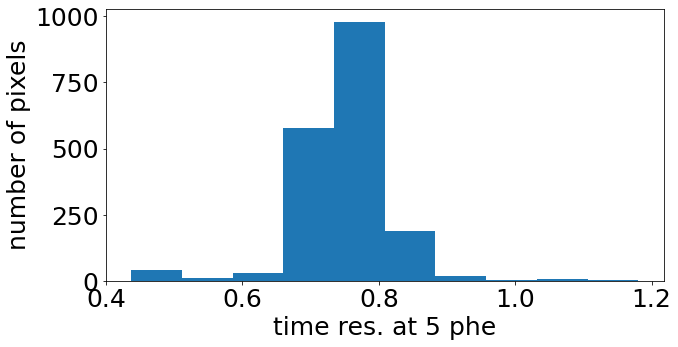

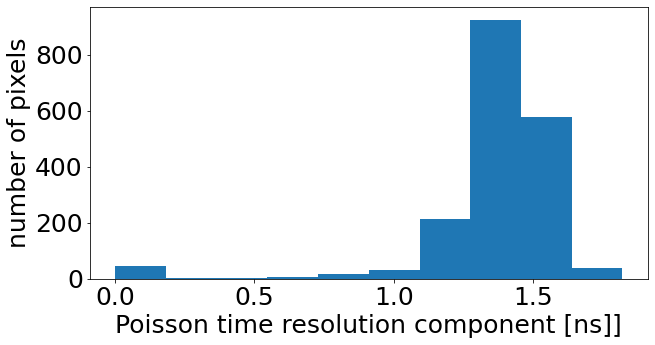

In [9]:
def fgauss (x, bgd, mean, sigma, norm):
    return bgd+ norm*np.exp(-(x-mean)**2/(2*sigma**2))

def func (x, t0, t1, t2):
    return np.sqrt(t0**2 + t1**2/x + (t2/x)**2)

val5phe=[]

poissonpar=[]

for pixid in range (npix):
    timeresy=[]
    timeresx=[]
    for binnr in range (1, nbins):
        numentries=len(alltimes[pixid,binnr])
        if numentries<mineventfit:
            continue
        meancharge=np.mean(allcharges[pixid,binnr])
        hist = np.histogram(alltimes[pixid,binnr], bins=30, range=(-5, 5))
        xs=hist[1][:-1]+0.5*(hist[1][1]-hist[1][0])
        ys=hist[0]
        #print ("mean Nphe = ",meancharge, ", num entries = ", numentries)


        meanp=np.mean(alltimes[pixid,binnr])
        sigmap=np.std(alltimes[pixid,binnr])
        norm0=max(ys)
        p0 = [0.1, meanp, sigmap, norm0]

        try:
            pars, cov = curve_fit(f=fgauss, xdata=xs, ydata=ys, p0=p0)
        except RuntimeError:
            pass
        
        timeresx.append(meancharge)
        timeresy.append(pars[2])

    # now do a fit for this pixel  
    p0=[1,1,1]
    if len(timeresy)>3:
        pars, cov = curve_fit(f=func, xdata=timeresx, ydata=timeresy, p0=p0, bounds=(0, 20))
        val5=func(5,*pars)
        print(pixid,pars, val5)
        val5phe.append(val5)
        poissonpar.append(pars[1])

plt.figure(figsize=(10, 5))

plt.hist(val5phe)
plt.xlabel('time res. at 5 phe')
plt.ylabel('number of pixels')

plt.figure(figsize=(10, 5))
plt.hist(poissonpar)
plt.xlabel('Poisson time resolution component [ns]]')
plt.ylabel('number of pixels')
